# Data Loading (Station 41025)

In this section, the historical buoy data for station 41025 is prepared for forecasting analysis. The raw observations are provided as separate compressed (.gz) files for each calendar year, spanning 2014 to 2019. To enable time-series modeling and walk-forward validation, these yearly files must first be combined into a single, continuous dataset.

Each yearly file is read, parsed, and standardized to ensure consistent column naming and timestamp formatting. Invalid or sentinel values used by the buoy system to represent missing measurements are converted to NaN to allow proper handling in later preprocessing steps. A unified datetime index is constructed from the provided year, month, day, and hour fields, and the data are sorted chronologically.

The resulting yearly datasets are then concatenated into one continuous time series covering the full 2014–2019 period. Duplicate timestamps, which may arise at year boundaries or during data overlaps, are removed to ensure temporal consistency.

At this stage, the dataset is not yet resampled, imputed, or feature-engineered. The objective here is solely to produce a clean, chronologically ordered raw time series that will serve as the foundation for subsequent steps, including missing-data analysis, lag-based feature construction, multi-horizon target generation, and forecasting model development.

In [4]:
import os
import glob
import pandas as pd

In [5]:
# Standard NDBC missing-value codes
NDBC_NA_VALS = [99, 99.0, 999, 999.0, 9999, 9999.0, "MM"]

In [6]:
def read_ndbc_stdmet(path: str) -> pd.DataFrame:
    """
    Read a single NDBC standard meteorological file (.txt).
    - Detects header line starting with '#YY' or 'YY'
    - Uses it as column names
    - Converts standard NDBC missing codes to NaN
    """
    header = None
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if line.startswith("#YY") or line.startswith("YY"):
                header = line.lstrip("#").strip().split()
                break

    if header is None:
        raise ValueError(f"Could not find NDBC header in {path}")

    df = pd.read_csv(
        path,
        sep=r"\s+",
        comment="#",
        header=None,
        names=header,
        na_values=NDBC_NA_VALS,
        engine="python",
    )

    return df


In [7]:
def build_station_41025(years):
    """
    Build a single cleaned DataFrame for station 41025
    from yearly files like 41025h2014.txt, 41025h2015.txt, ...
    """
    files = sorted(
        f for f in glob.glob("41025h*.txt")
        if any(str(y) in os.path.basename(f) for y in years)
    )

    if not files:
        raise FileNotFoundError(
            "No files found matching 41025h*.txt for years "
            f"{years} in {os.getcwd()}"
        )

    print(f"Found {len(files)} files for station 41025:")
    for f in files:
        print(" -", os.path.basename(f))

    dfs = [read_ndbc_stdmet(f) for f in files]
    df = pd.concat(dfs, ignore_index=True)

    # Standardize time columns
    col_map = {
        "#YY": "year", "YY": "year",
        "MM": "month",
        "DD": "day",
        "hh": "hour",
        "mm": "minute"
    }
    df = df.rename(columns={k: v for k, v in col_map.items() if k in df.columns})

    # Build datetime index
    if "minute" not in df.columns:
        df["minute"] = 0

    df["datetime"] = pd.to_datetime(
        df[["year", "month", "day", "hour", "minute"]],
        errors="coerce"
    )

    df = (
        df.dropna(subset=["datetime"])
          .set_index("datetime")
          .sort_index()
    )

    # Drop raw time columns
    df = df.drop(columns=["year", "month", "day", "hour", "minute"], errors="ignore")

    return df


In [8]:
years = [2014, 2015, 2016, 2017, 2018, 2019]

df_41025 = build_station_41025(years)

Found 6 files for station 41025:
 - 41025h2014.txt
 - 41025h2015.txt
 - 41025h2016.txt
 - 41025h2017.txt
 - 41025h2018.txt
 - 41025h2019.txt


In [9]:
keep_cols = [c for c in ["WVHT", "APD", "WSPD", "PRES", "ATMP", "WTMP", "GST"]
             if c in df_41025.columns]

df_41025 = df_41025[keep_cols]

In [10]:
print("Index range:", df_41025.index.min(), "→", df_41025.index.max())
print("Shape:", df_41025.shape)
print("\nMissingness (%):")
print(df_41025.isna().mean().sort_values(ascending=False))

df_41025.head()

Index range: 2013-12-31 23:50:00 → 2019-12-31 23:50:00
Shape: (117882, 7)

Missingness (%):
WVHT    0.624413
APD     0.624413
ATMP    0.068221
WTMP    0.044723
GST     0.009238
WSPD    0.009213
PRES    0.001798
dtype: float64


,WVHT,APD,WSPD,PRES,ATMP,WTMP,GST
datetime,,,,,,,
2013-12-31 23:50:00,0.96,4.41,7.0,1025.5,11.8,23.3,10.0
2014-01-01 00:50:00,0.96,4.40,6.8,1026.6,11.8,23.3,9.5
2014-01-01 01:50:00,0.89,4.23,7.5,1027.6,11.9,23.3,9.5
2014-01-01 02:50:00,0.89,4.15,6.6,1027.9,11.7,23.3,9.4
2014-01-01 03:50:00,0.92,4.38,7.0,1027.9,12.0,23.2,10.1


In [12]:
df_41025 = df_41025.asfreq("1H")

C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\110875115.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_41025 = df_41025.asfreq("1H")


In [13]:
df_41025

,WVHT,APD,WSPD,PRES,ATMP,WTMP,GST
datetime,,,,,,,
2013-12-31 23:50:00,0.96,4.41,7.0,1025.5,11.8,23.3,10.0
2014-01-01 00:50:00,0.96,4.40,6.8,1026.6,11.8,23.3,9.5
2014-01-01 01:50:00,0.89,4.23,7.5,1027.6,11.9,23.3,9.5
2014-01-01 02:50:00,0.89,4.15,6.6,1027.9,11.7,23.3,9.4
2014-01-01 03:50:00,0.92,4.38,7.0,1027.9,12.0,23.2,10.1
...,...,...,...,...,...,...,...
2019-12-31 19:50:00,NaN,NaN,6.9,1007.6,15.2,22.1,10.0
2019-12-31 20:50:00,NaN,NaN,7.4,1007.8,15.2,22.3,10.0
2019-12-31 21:50:00,NaN,NaN,7.4,1008.2,15.4,22.8,10.0


In [14]:
for col in ["WVHT", "APD"]:
    df_41025[f"{col}_missing"] = df_41025[col].isna().astype(int)

In [15]:
df_41025[["WVHT", "APD"]] = (
    df_41025[["WVHT", "APD"]]
    .interpolate(limit=3, limit_direction="forward")
)

In [16]:
print("Final missingness (%):")
print(df_41025.isna().mean().sort_values(ascending=False))

df_41025.head()


Final missingness (%):
WVHT            0.424094
APD             0.424094
WTMP            0.244766
ATMP            0.226034
GST             0.173795
WSPD            0.173738
PRES            0.156489
WVHT_missing    0.000000
APD_missing     0.000000
dtype: float64


,WVHT,APD,WSPD,PRES,ATMP,WTMP,GST,WVHT_missing,APD_missing
datetime,,,,,,,,,
2013-12-31 23:50:00,0.96,4.41,7.0,1025.5,11.8,23.3,10.0,0,0
2014-01-01 00:50:00,0.96,4.40,6.8,1026.6,11.8,23.3,9.5,0,0
2014-01-01 01:50:00,0.89,4.23,7.5,1027.6,11.9,23.3,9.5,0,0
2014-01-01 02:50:00,0.89,4.15,6.6,1027.9,11.7,23.3,9.4,0,0
2014-01-01 03:50:00,0.92,4.38,7.0,1027.9,12.0,23.2,10.1,0,0


## Short gaps (≤3 h) were interpolated(fill forward) , while longer gaps were retained as missing and will be excluded from training windows

In [17]:
# Require all core inputs to be present for a window
required_cols = ["WVHT", "APD", "WSPD", "PRES", "ATMP", "WTMP", "GST"]

df_model = df_41025.dropna(subset=required_cols)
print("Model-ready shape:", df_model.shape)


Model-ready shape: (22873, 9)


## Build lag features

In [18]:
L = 24  # 24-hour history

for col in ["WVHT", "APD"]:
    for l in range(1, L + 1):
        df_model[f"{col}_lag{l}"] = df_model[col].shift(l)

df_model = df_model.dropna()
print("After lagging:", df_model.shape)


After lagging: (22849, 57)


C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1017906545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[f"{col}_lag{l}"] = df_model[col].shift(l)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1017906545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[f"{col}_lag{l}"] = df_model[col].shift(l)
C:\Users\attafuro\AppData\Local\Temp\ipykernel_60840\1017906545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

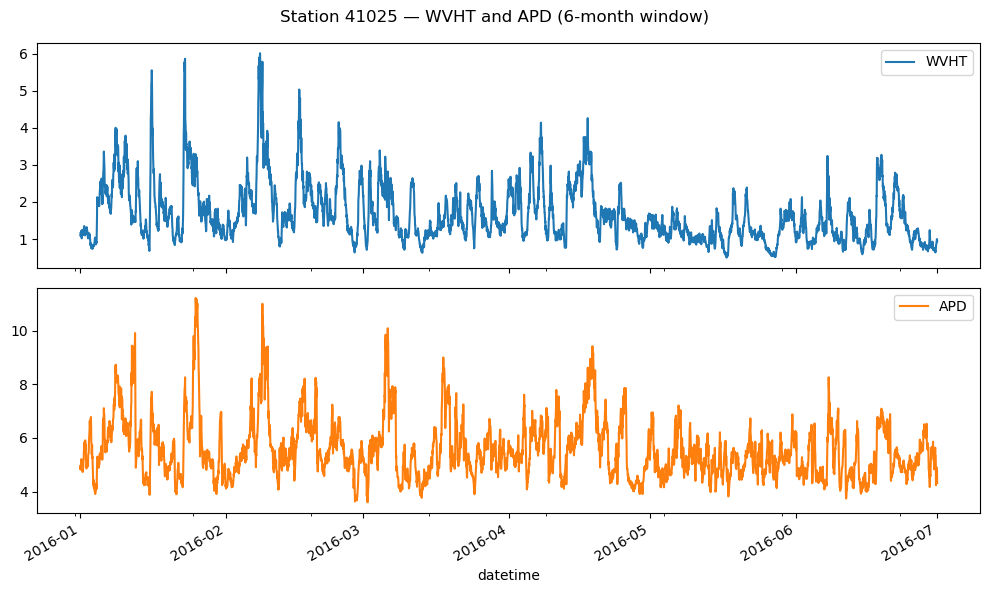

In [20]:
df_41025.loc["2016-01":"2016-06", ["WVHT", "APD"]].plot(
    subplots=True, sharex=True, figsize=(10,6)
)
plt.suptitle("Station 41025 — WVHT and APD (6-month window)")
plt.tight_layout()
plt.show()


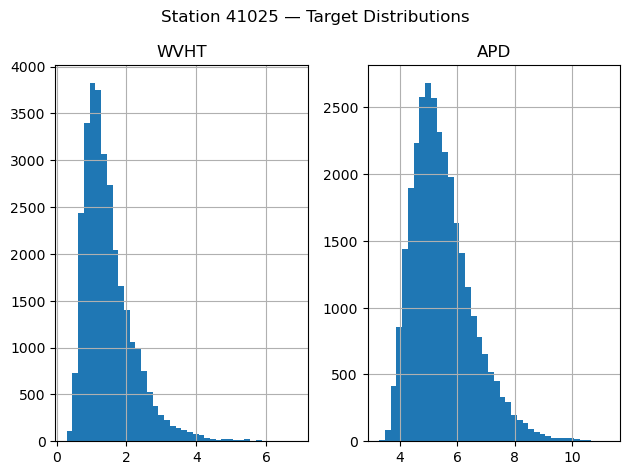

In [21]:
df_41025[["WVHT", "APD"]].hist(bins=40)
plt.suptitle("Station 41025 — Target Distributions")
plt.tight_layout()
plt.show()
